# Point-scanning micro-endoscopy through a multimode fiber

See section 2.5 in the paper for the full experiment.

The data we use in this notebook comes from [Turcotte et al.](https://opg.optica.org/boe/fulltext.cfm?uri=boe-11-8-4759&id=433935) Refer to them for further details about the data as well as some of the basic image processing.

See the demo.ipynb for a more basic tutorial

## Setup

Here we import some necessary packages/helper functions

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..") # since the package is one level above. Normally you should keep them on the same!

!export CUDA_VISIBLE_DEVICES=0,1,2,3 # REPLACE this line according to your GPUs

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3" # REPLACE this line according to your GPUs

import rdmpy

# here are some basics we will need for the demo
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Fill this in according to your computer, we highly recommend using a GPU.
# We needed ~20GB of GPU memory to run at full resolution (1024 x 1024).
if torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')
    
    
print('Using ' +str(device) + ' for computation')

def center_crop(img, des_shape, m_center=None):
    if m_center is None:
        m_center = (img.shape[0] // 2, img.shape[1] // 2)
    left, right, up, down = (
        m_center[1] - des_shape[1] // 2,
        m_center[1] + int(np.round(des_shape[1] / 2)),
        m_center[0] - des_shape[0] // 2,
        m_center[0] + int(np.round(des_shape[0] / 2)),
    )
    img = img[up:down, left:right]
    return img

def crop(img, c):
    return img[c:-c,c:-c]

BLUE = 488e-9

/home/amit/micromamba/envs/psf/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Using cuda:1 for computation


## One-time Calibration

Here the calibration image is 5 randomly scattered 0.1 micron beads. 

In [6]:
dim = 120
upsample = 3 # upsampling factor chosen by the Turcotte et al. for smoothing.
dim = dim*upsample

In [ ]:
base_dir=''

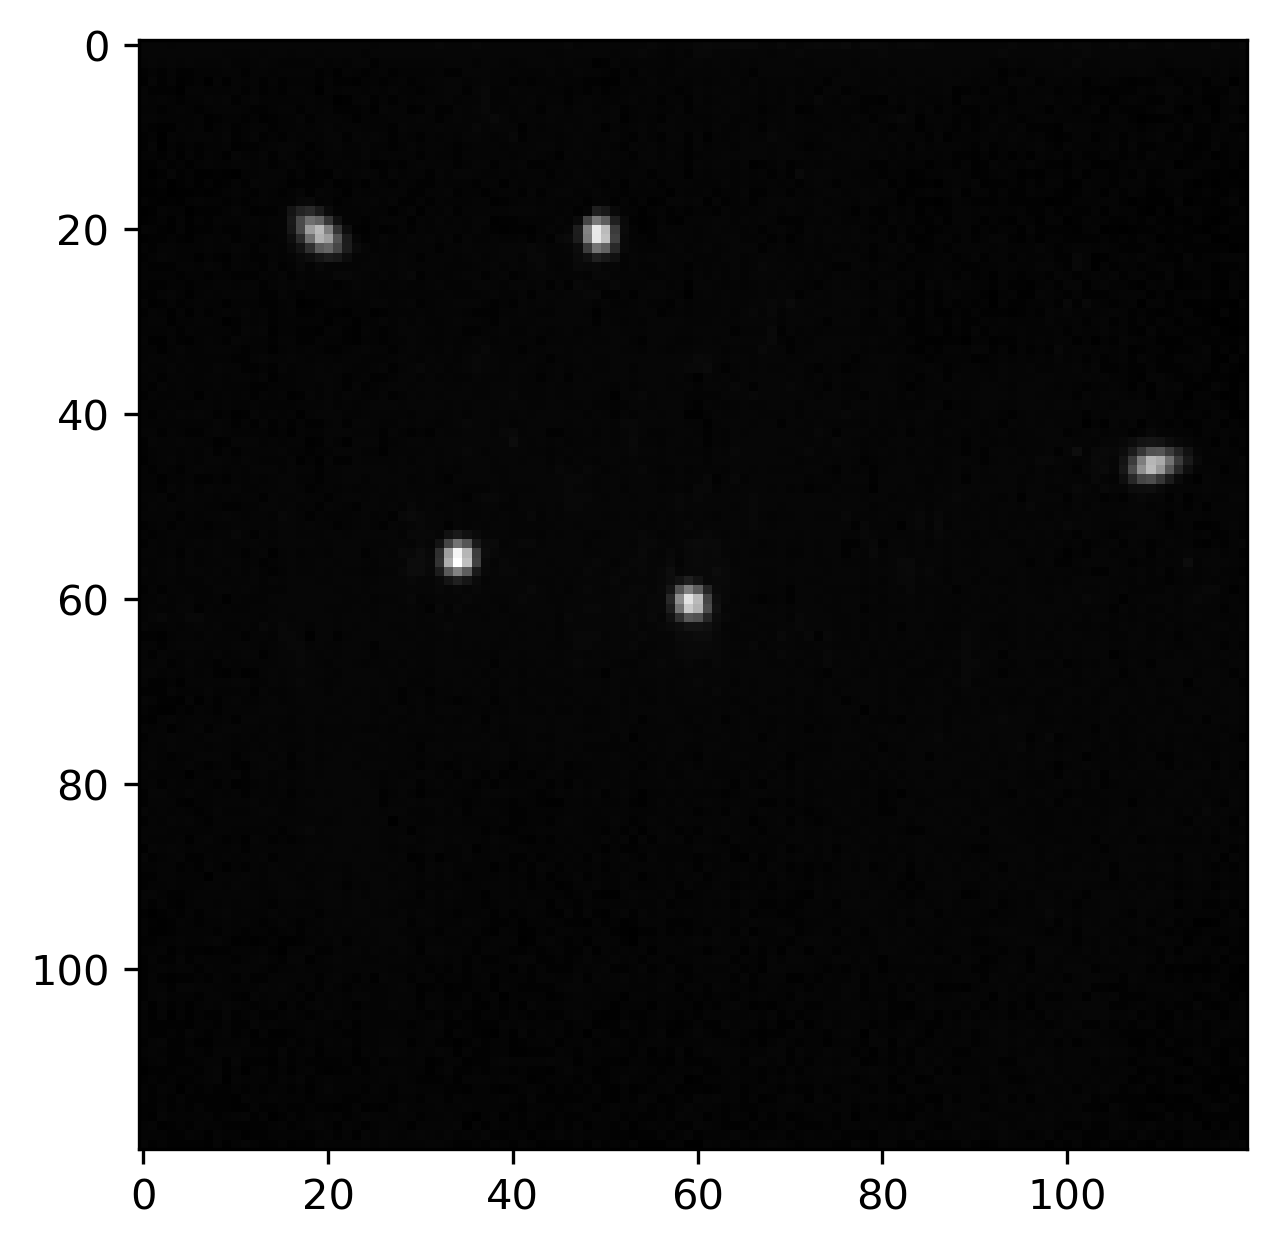

In [8]:
calibration_image = plt.imread(base_dir+'rdm_data/mmf/calibration/calib_img.tif').copy()
plt.imshow(calibration_image, cmap='gray')
plt.show()

fitting seidel coefficients...


100%|██████████| 500/500 [00:09<00:00, 54.38it/s]


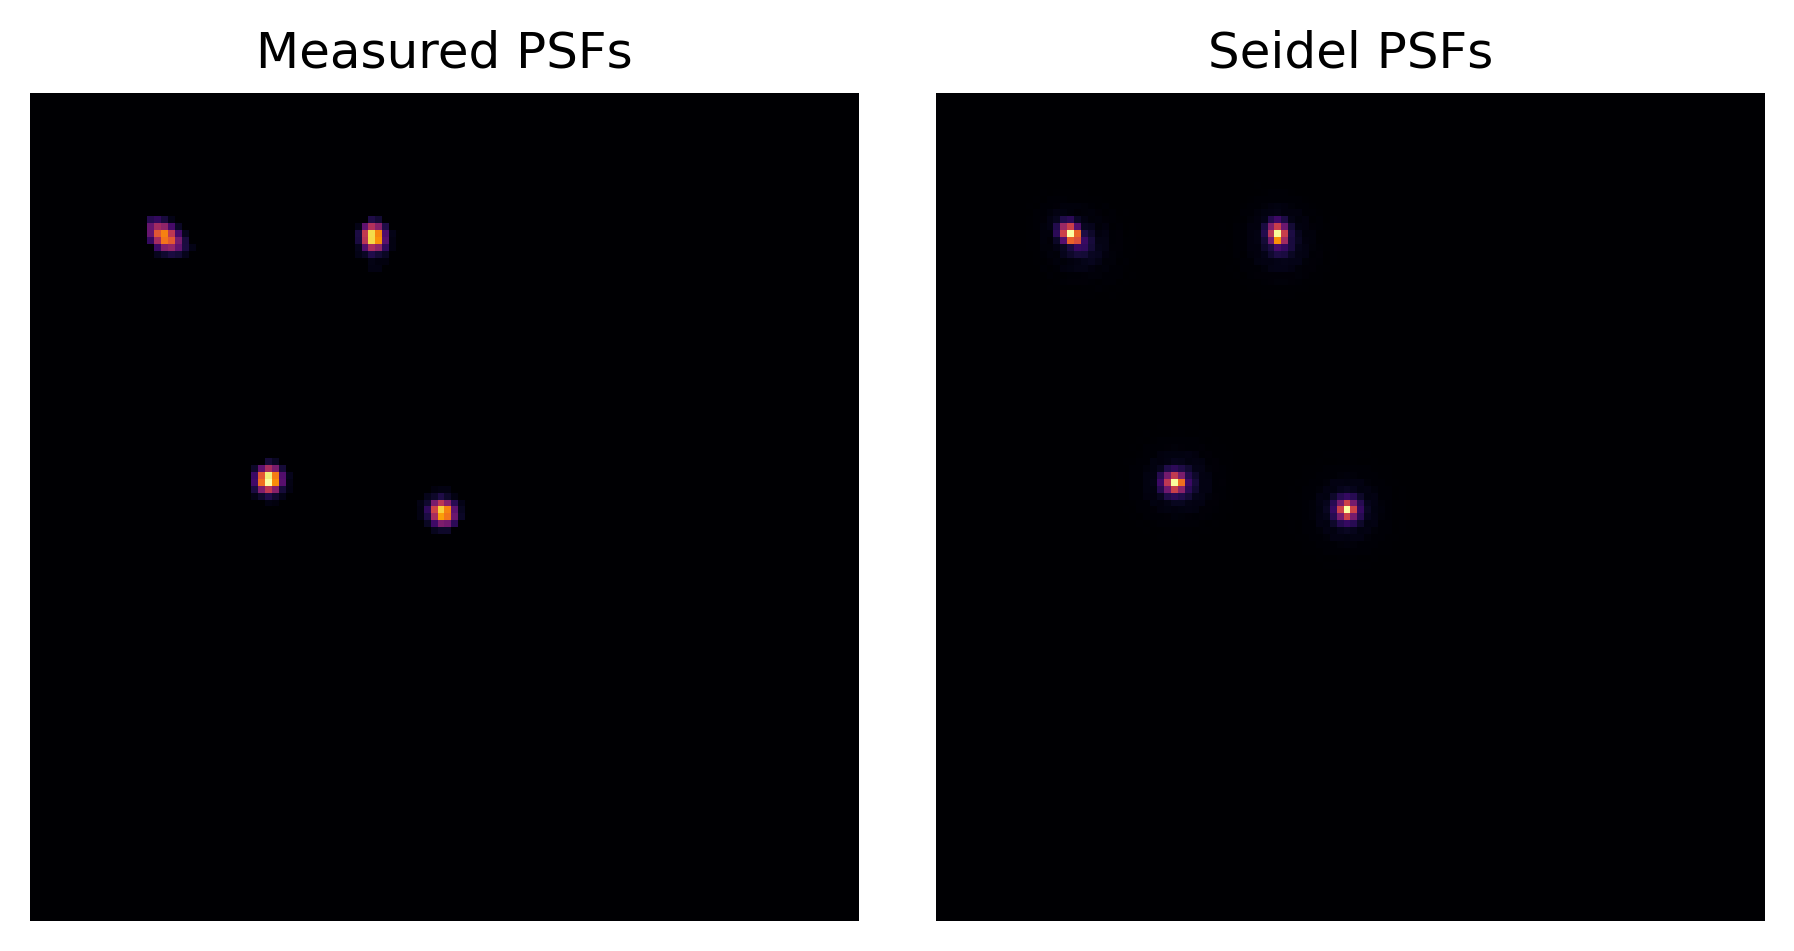

Fitted seidel coefficients: tensor([[0.5011],
        [0.2658],
        [0.2273],
        [0.1349],
        [0.0000],
        [0.0000]])


In [9]:
fit_params={
        "iters": 500,
        "threshold": 0.1,
        "disk": 1,
        "lr": 1e-3,
        "min_distance": 10,
    }


seidel_coeffs = rdmpy.calibrate_rdm(calibration_image, dim=dim//upsample, device=device, show_psfs=True, get_psfs=False, sys_params={"lamb": BLUE}, fit_params=fit_params)

## 1 micron beads
Now that we have our fitted Seidel coefficients, we can deblur some 1 micron beads with ring deconvolution. First we render out upsampled PSFs using the rdmpy upsampling feature. Then we deblur 2 instances of 1 micron bead distributions. 


In [10]:
# render the PSFs (normally would do this in the previous step, but we want to upsample them for the beads)
upsampled_psfs = rdmpy.get_rdm_psfs(
    seidel_coeffs,
    dim // upsample,
    model="lri",
    sys_params={"lamb": BLUE},
    downsample=1 / upsample,
    device=device,
)

rendering PSFs...


100%|██████████| 360/360 [00:08<00:00, 40.78it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [05:42<00:00,  1.46it/s]


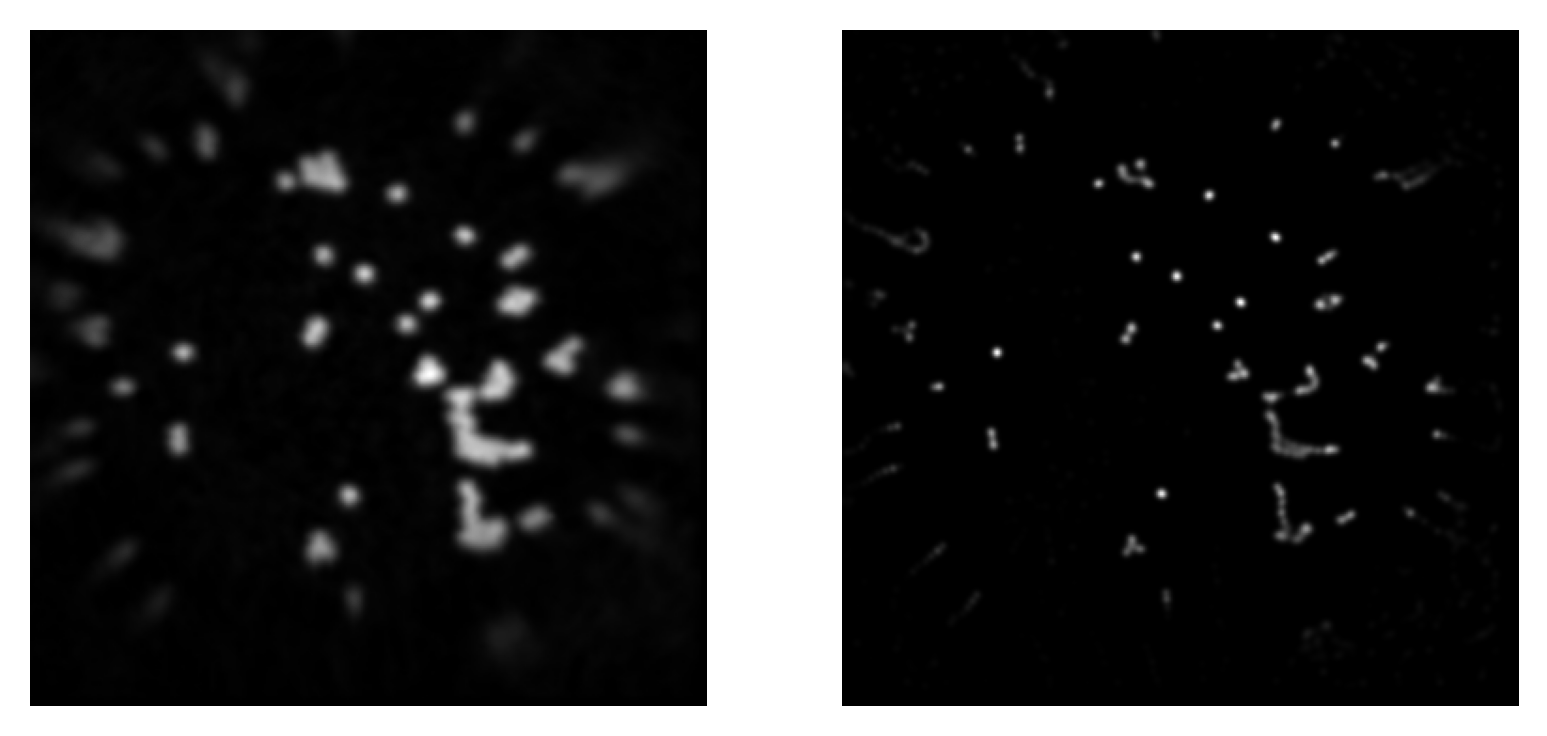

In [12]:
beads1 = plt.imread(base_dir+'rdm_data/mmf/beads/Set3-3x.tif') / 255.0
beads1 = np.concatenate([beads1, np.zeros([3, dim - 3])], axis=0) # these 2 lines correct dimension mismatch
beads1 = np.concatenate([beads1, np.zeros([dim, 3])], axis=1)
#now deblur with ring deconvolution
beads1_recon = rdmpy.ring_deconvolve(
    beads1,
    upsampled_psfs,
    process=False,
    iters=500,
    lr=1e-1,
    tv_reg=1e-10,
    l2_reg=1e-8,
    device=device,
)

beads1_recon = gaussian_filter(beads1_recon, sigma=(3.0 / 2.0)) # Gaussian blur as per Turcotte et al.
beads1_recon = beads1_recon/beads1_recon.max()

# plot raw and ring deconvolved beads
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(beads1, cmap='gray')
ax1.axis('off')
ax2.imshow(beads1_recon, cmap='gray')
ax2.axis('off') 
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [05:40<00:00,  1.47it/s]


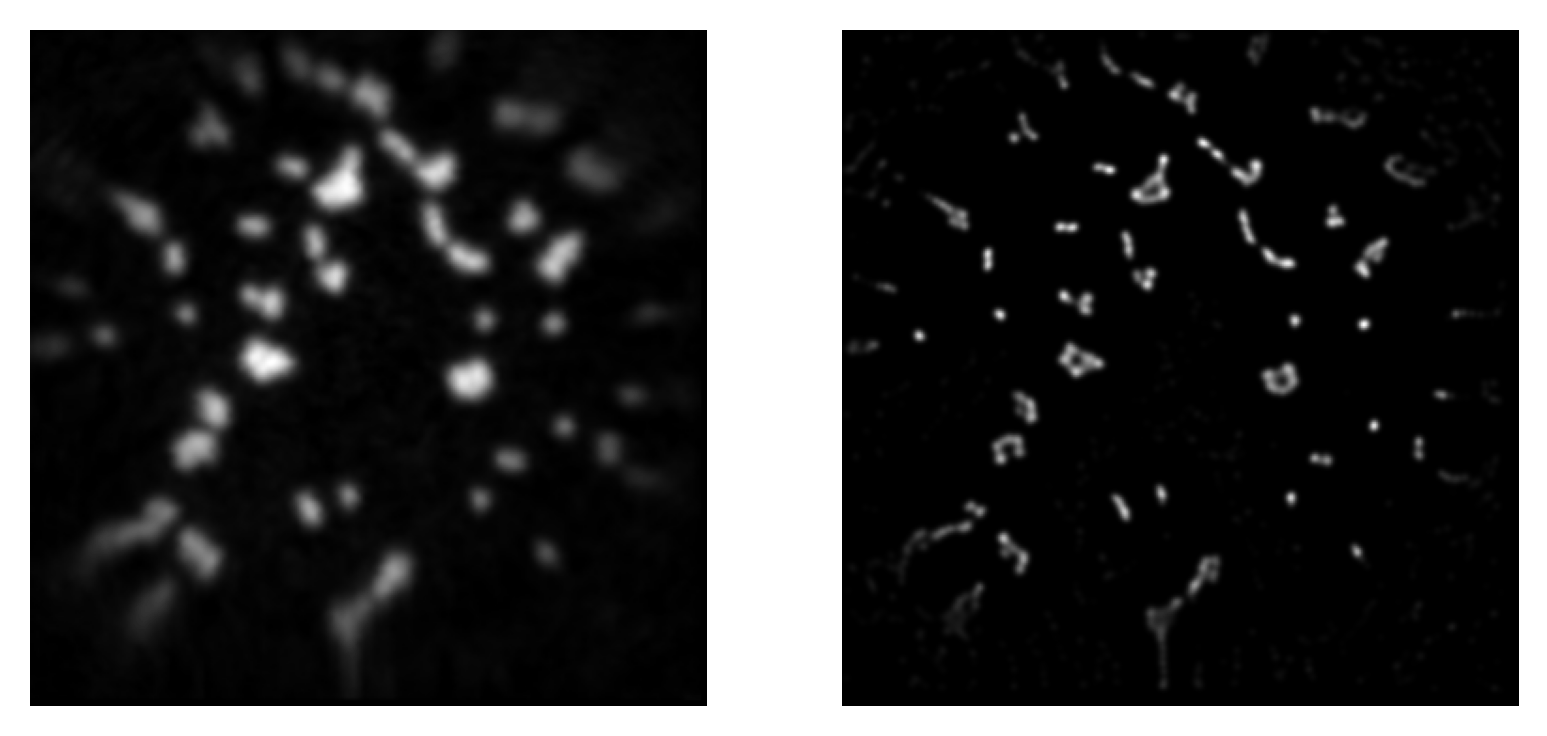

In [14]:
beads2 = plt.imread(base_dir+'rdm_data/mmf/beads/Set2-3x.tif') / 255.0
beads2 = np.concatenate([beads2, np.zeros([3, dim - 3])], axis=0) # these 2 lines correct dimension mismatch
beads2 = np.concatenate([beads2, np.zeros([dim, 3])], axis=1)
#now deblur with ring deconvolution
beads2_recon = rdmpy.ring_deconvolve(
    beads2,
    upsampled_psfs,
    process=False,
    iters=500,
    lr=1e-1,
    tv_reg=1e-10,
    l2_reg=1e-8,
    device=device,
)

beads2_recon = gaussian_filter(beads2_recon, sigma=(3.0 / 2.0)) # Gaussian blur as per Turcotte et al.
beads2_recon = beads2_recon/beads2_recon.max()

# plot raw and ring deconvolved beads
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(beads2, cmap='gray')
ax1.axis('off')
ax2.imshow(beads2_recon, cmap='gray')
ax2.axis('off') 
plt.show()

## Live rat neurons
We can apply the same strategy to live rat neurons. We won't upsample this time in accordance with Turcotte et al.

In [15]:
# get the non-upsampled PSFs from the seidel coefficients
seidel_psfs = rdmpy.get_rdm_psfs(
    seidel_coeffs,
    dim // upsample,
    model="lri",
    sys_params={"lamb": BLUE},
    device=device,
)

rendering PSFs...


100%|██████████| 120/120 [00:00<00:00, 231.51it/s]


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [01:08<00:00,  4.40it/s]


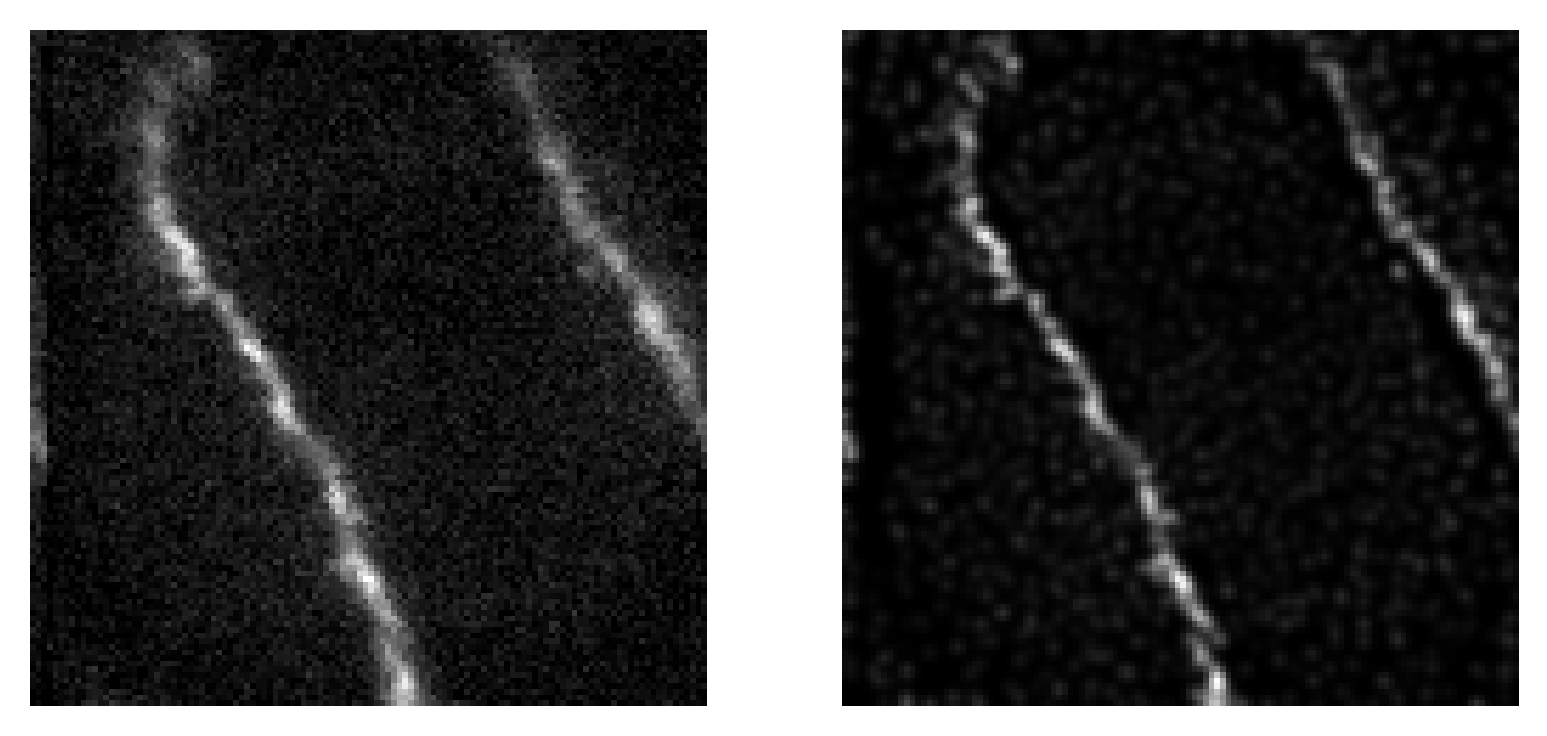

In [16]:
neurons1 = plt.imread(base_dir+'rdm_data/mmf/neurons/163424f.tif') / 255.0
#now deblur with ring deconvolution
neurons1_recon = rdmpy.ring_deconvolve(
    neurons1,
    seidel_psfs,
    process=False,
    iters=300,
    lr=5e-2,
    tv_reg=1e-10,
    l2_reg=1e-8,
    device=device,
)

neurons1_recon = gaussian_filter(neurons1_recon, sigma=(3.0 / 3.0)) # Gaussian blur as per Turcotte et al.
neurons1_recon = neurons1_recon/neurons1_recon.max()

# plot raw and ring deconvolved neurons
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(neurons1, cmap='gray')
ax1.axis('off')
ax2.imshow(neurons1_recon, cmap='gray')
ax2.axis('off') 
plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [01:07<00:00,  4.42it/s]


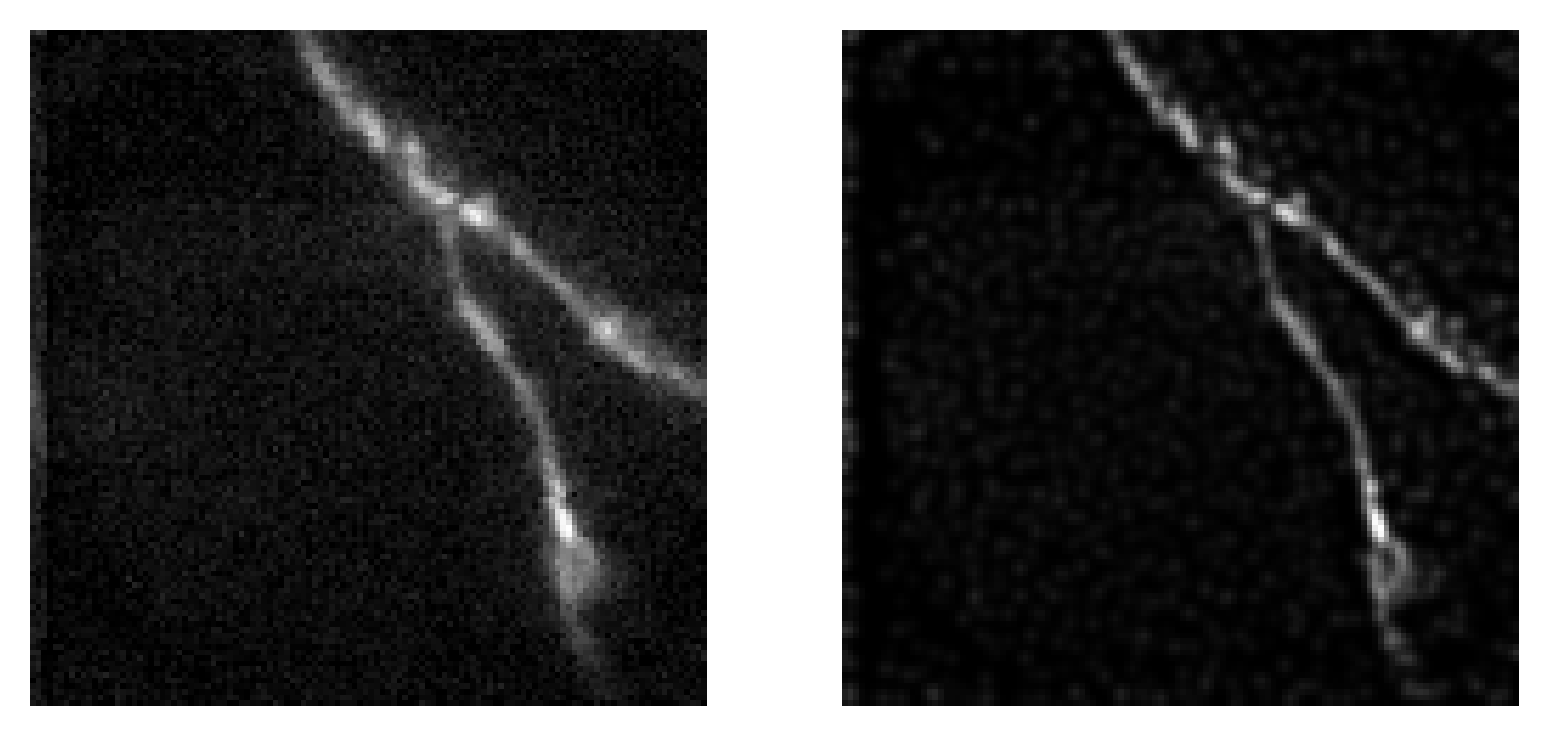

In [17]:
neurons2 = plt.imread(base_dir+'rdm_data/mmf/neurons/154624f.tif') / 255.0
#now deblur with ring deconvolution
neurons2_recon = rdmpy.ring_deconvolve(
    neurons2,
    seidel_psfs,
    process=False,
    iters=300,
    lr=5e-2,
    tv_reg=1e-10,
    l2_reg=1e-8,
    device=device,
)

neurons2_recon = gaussian_filter(neurons2_recon, sigma=(3.0 / 3.0)) # Gaussian blur as per Turcotte et al.
neurons2_recon = neurons2_recon/neurons2_recon.max()

# plot raw and ring deconvolved neurons
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(neurons2, cmap='gray')
ax1.axis('off')
ax2.imshow(neurons2_recon, cmap='gray')
ax2.axis('off') 
plt.show()